# Training a model from ACDC dataset

**Authors :**
* _Louis Lacroix_
* _Benjamin Ternot_

## I. Importing Libraries and Global Settings

In [1]:
import datetime
import gc
import os
from functools import partial

import psutil

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam

from data_manager.datamanager import DataLoader
from models.model import Unet
from models.modeltrainer import ModelPreprocessor, DiffusionModelTrainer, Diffusion
from utils.utils import VerboseLevel

In [2]:
# Parameters to use for the preprocessing
IMAGE_SIZE=128
PADDING=0.2
IMAGE_NAMES=["ED_gt", "ES_gt"]
LINK_GT_TO_DATA=False
KEEP_3D_CONSISTENCY=False
CHANNELS=4
RESCALE_OUTPUT_KEY="rescaled_image_data"
MAX_ANGLE=45
NB_ROTATIONS=7
VERBOSE=VerboseLevel.DISPLAY
# VerboseLevel.NONE to avoid outputs
# VerboseLevel.TQDM to use tqdm progress bars
# VerboseLevel.PRINT to print information
# VerboseLevel.DISPLAY to display images

# Execution parameters
LIBERATE_MEMORY=True
CUDA_DEVICE = 2

# Parameters for the model training
SAVE_MODEL = True
SAVE_INTERMEDIATE_MODELS = {"toggle": False, "frequency": 20}

# Model parameters
BATCH_SIZE = 16
EPOCHS = 100
T = 1000
DIM_MULTS = (1, 2, 4, 8)

In [3]:
# Modifier les couleurs des textes et des axes en fonction du thème de Jupyter
DARK_BG = False

if DARK_BG:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
else:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'

## II. Data Loading and Preprocessing

In [4]:
# Define the root data folder
root_data_folder = os.path.join(os.path.dirname(os.getcwd()), 'database')

# Define the sub path to the folders containing the data
data_sub_folders = {
    "train": "training",
    "test": "testing",
}

# Define the mapping from group labels to diagnostic classes
group_map = {
    "NOR": "Healthy control",
    "MINF": "Myocardial infarction",
    "DCM": "Dilated cardiomyopathy",
    "HCM": "Hypertrophic cardiomyopathy",
    "RV": "Abnormal right ventricle"
}

In [5]:
# Create the data loader
data_loader = DataLoader(root_folder=root_data_folder)

# Load the data
for key, sub_folder in data_sub_folders.items():
    data_loader.load_data(sub_folder, name=key, store=True, verbose=VERBOSE)

# Create the model trainer
model_preprocessor = ModelPreprocessor(data_loader, group_map)

Loading data in '/home/infres/bternot-21/PRIM-AI-Diffusion-Models-for-Cardiac-Images/database/training':   0%|…

Loading data in '/home/infres/bternot-21/PRIM-AI-Diffusion-Models-for-Cardiac-Images/database/testing':   0%| …

Transforming images in 'train':   0%|          | 0/100 [00:00<?, ?it/s]

Transforming images in 'test':   0%|          | 0/50 [00:00<?, ?it/s]

data_loader.data
├── train
│	├── patient093
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── rescaled_image_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient077
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── rescaled_image_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient099
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── rescaled_image_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient038
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height
│	│	├── weight
│	│	├── group
│	│	├── nb_frames
│	│	├── rescaled_image_data
│	│	│	├── ED_gt
│	│	│	├── ES_gt
│	├── patient032
│	│	├── image_data
│	│	│	├── ED
│	│	│	├── ED_gt
│	│	│	├── ES
│	│	│	├── ES_gt
│	│	├── height


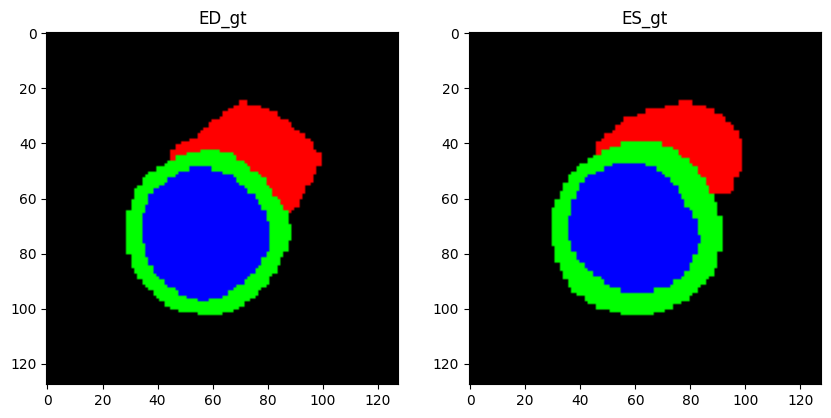

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient105, height: 173.0cm, weight: 84.0kg, group: HCM, nb_frames: 30


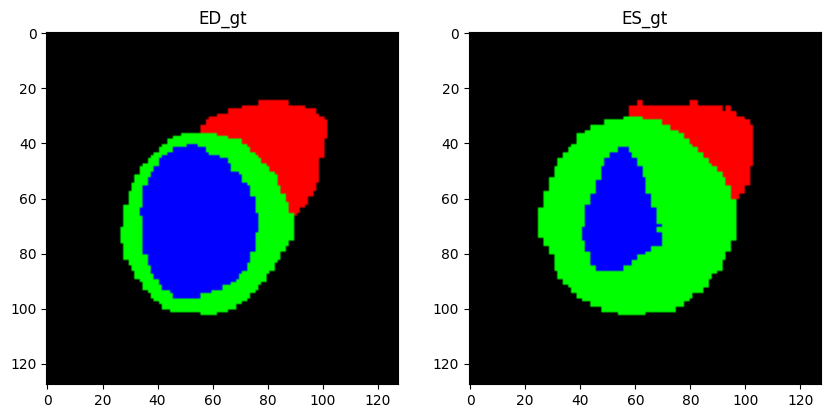

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient135, height: 184.0cm, weight: 95.0kg, group: MINF, nb_frames: 20


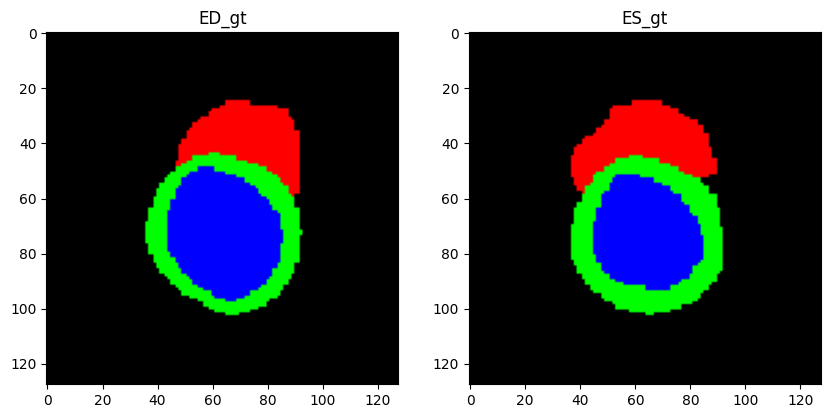

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient123, height: 170.0cm, weight: 70.0kg, group: NOR, nb_frames: 30


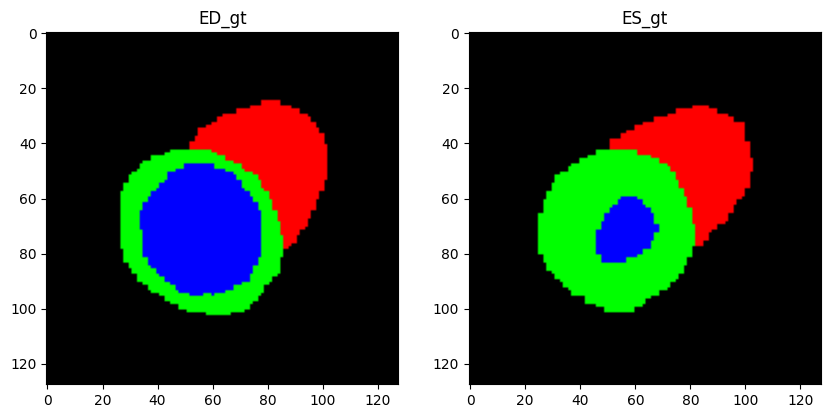

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient127, height: 165.0cm, weight: 54.0kg, group: RV, nb_frames: 18


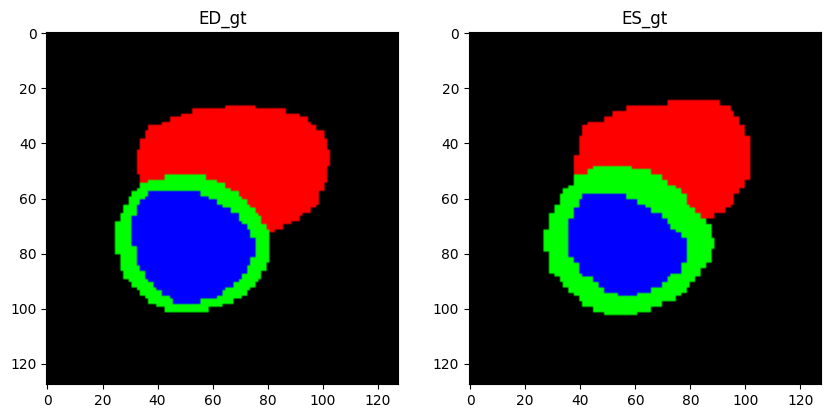

##########################################################################################
train data :
	------------------------------------------------------------
	Dilated cardiomyopathy :		
		
			ID: patient020, height: 182.0cm, weight: 106.0kg, group: DCM, nb_frames: 20


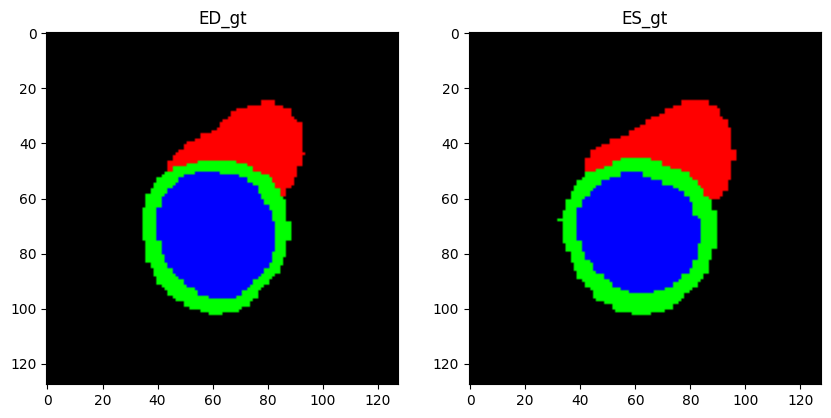

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :		
		
			ID: patient033, height: 165.0cm, weight: 89.0kg, group: HCM, nb_frames: 30


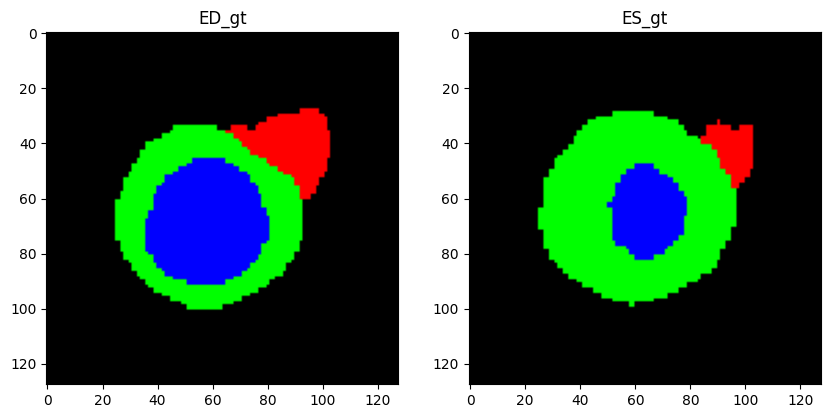

	------------------------------------------------------------
	Myocardial infarction :		
		
			ID: patient049, height: 171.0cm, weight: 72.0kg, group: MINF, nb_frames: 35


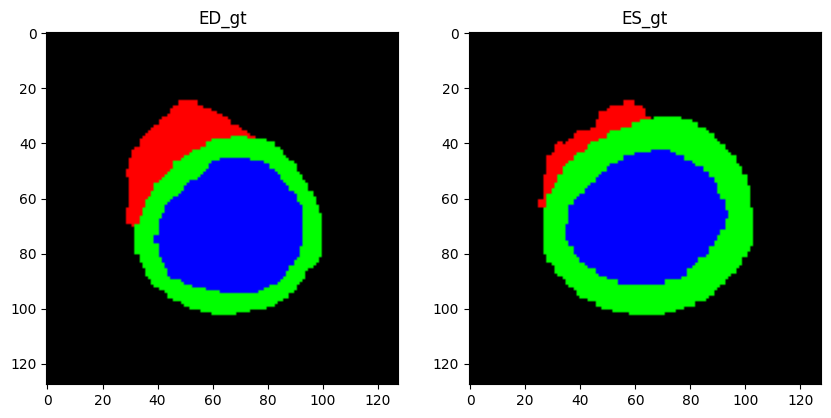

	------------------------------------------------------------
	Healthy control :		
		
			ID: patient065, height: 180.0cm, weight: 92.0kg, group: NOR, nb_frames: 30


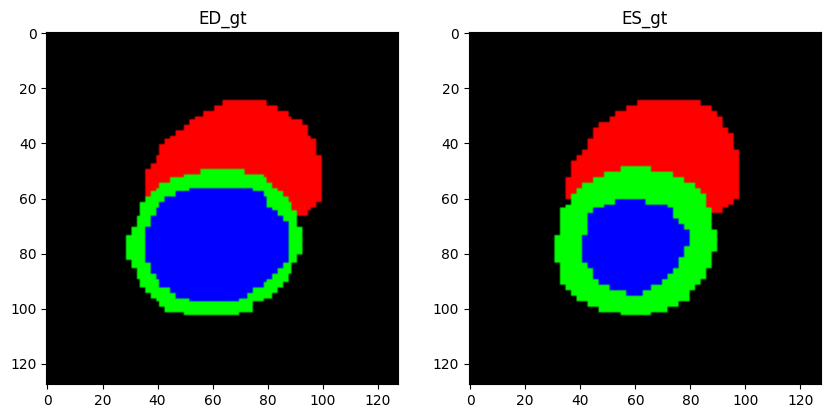

	------------------------------------------------------------
	Abnormal right ventricle :		
		
			ID: patient094, height: 164.0cm, weight: 45.0kg, group: RV, nb_frames: 14


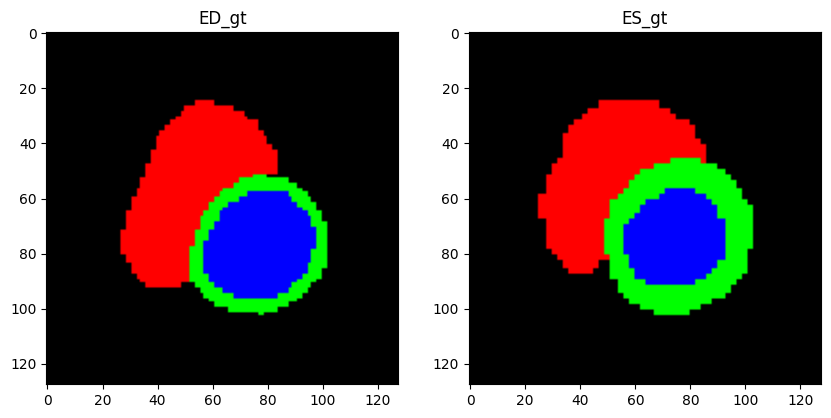

Extracting images in 'train':   0%|          | 0/100 [00:00<?, ?it/s]

Extracting images in 'test':   0%|          | 0/50 [00:00<?, ?it/s]

Rotating images:   0%|          | 0/7 [00:00<?, ?it/s]

Number of images after rotation: 2100


Slicing images:   0%|          | 0/2100 [00:00<?, ?it/s]

Number of images after slicing: 20846
No one-hot encoding applied


Normalizing images:   0%|          | 0/20846 [00:00<?, ?it/s]

In [6]:
# Preprocess the data
preprocessed_data = model_preprocessor.preprocess_data(
    target_shape=(IMAGE_SIZE, IMAGE_SIZE),
    padding=PADDING,
    image_names=IMAGE_NAMES,
    link_gt_to_data=LINK_GT_TO_DATA,
    keep_3d_consistency=KEEP_3D_CONSISTENCY,
    create_channels_from_gt=CHANNELS>1,
    rescale_output_key=RESCALE_OUTPUT_KEY,
    max_angle=MAX_ANGLE,
    nb_rotations=NB_ROTATIONS,
    verbose=VERBOSE
)

In [7]:
# Liberate memory if needed
def get_memory_usage():
    """Return the memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1e6

if LIBERATE_MEMORY:
    memory_before = get_memory_usage()
    del data_loader
    del model_preprocessor
    gc.collect()
    memory_after = get_memory_usage()
    if VERBOSE >= VerboseLevel.PRINT:
        print(f"Memory usage before: {memory_before/1000:.4f} GB"
              f"\nMemory usage after: {memory_after/1000:.4f} GB"
              f"\nMemory liberated: {memory_before - memory_after:.2f} MB"
        )

Memory usage before: 12.9147 GB
Memory usage after: 12.9077 GB
Memory liberated: 6.98 MB


## III. Model Training

In [8]:
# Define the root data folder
ROOT_RES_FOLDER = os.path.join(os.path.dirname(os.getcwd()), 'resources')

# Saving paths
current_datetime = datetime.datetime.now()

IMAGES_SAVE_FOLDER = os.path.join(
    ROOT_RES_FOLDER,
    "images",
    f"{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + (f'{CHANNELS}-channels' if CHANNELS>1 else '1-channel'),
    "training"
)
IMAGES_SAVE_PATH = os.path.join(IMAGES_SAVE_FOLDER, "{}")

MODEL_SAVE_FOLDER = os.path.join(
    ROOT_RES_FOLDER,
    "trained_models",
    f"{current_datetime.strftime('%Y-%m-%d-%H-%M')}_" + (f'{CHANNELS}-channels' if CHANNELS>1 else '1-channel')
)
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_FOLDER, "{}_unet.pt")
PARAMS_SAVE_PATH = os.path.join(MODEL_SAVE_FOLDER, "params.txt")

# Create folders to save the models
os.makedirs(IMAGES_SAVE_FOLDER, exist_ok=True)
os.makedirs(MODEL_SAVE_FOLDER, exist_ok=True)

In [9]:
# Write parameters to the file
SAVE_PARAMS = {
    "IMAGE_SIZE": IMAGE_SIZE,
    "CHANNELS": CHANNELS,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "T": T,
    "DIM_MULTS": DIM_MULTS
}
with open(PARAMS_SAVE_PATH, "w") as file:
    for key, value in SAVE_PARAMS.items():
        file.write(f"{key} = {value}\n")
if VERBOSE >= VerboseLevel.PRINT:
    print(f"Parameters saved to '{PARAMS_SAVE_PATH}'")

Parameters saved to '/home/infres/bternot-21/PRIM-AI-Diffusion-Models-for-Cardiac-Images/resources/trained_models/2025-01-05-22-14_4-channels/params.txt'


In [10]:
device = torch.device(f"cuda:{CUDA_DEVICE}" if torch.cuda.is_available() else "cpu")

18752 images (1172 batchs) for train, 2080 images (130 batchs) for validation, (90.0%-10.0%)
14 images left unused.


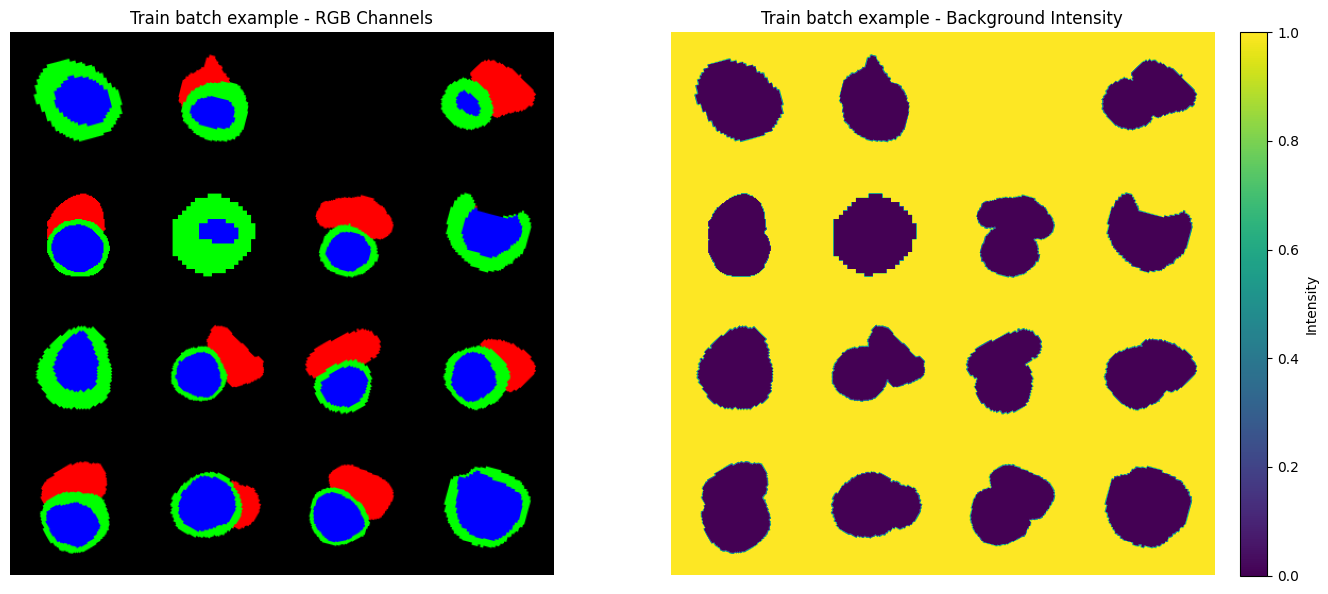

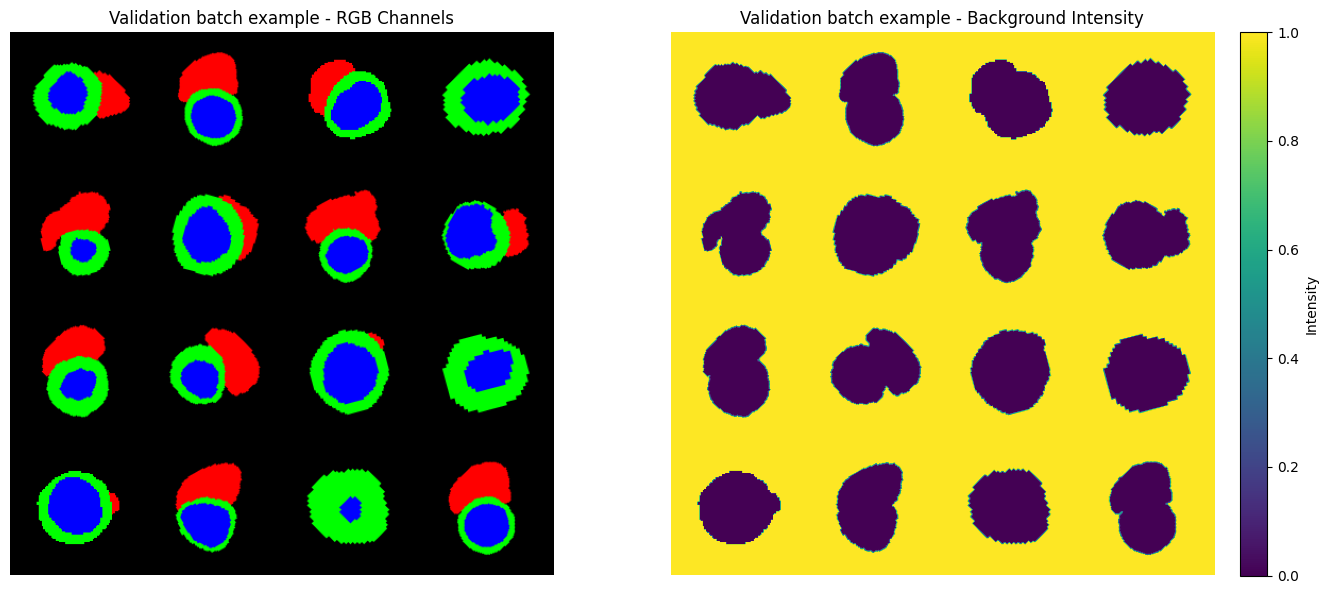

In [11]:
# Define the model
model = Unet(
    dim=IMAGE_SIZE,
    init_dim=None,
    out_dim=None,
    dim_mults=DIM_MULTS,
    channels= CHANNELS,
    with_time_emb=True,
    convnext_mult=2,
).to(device)
model_trainer = DiffusionModelTrainer(
    data_set=preprocessed_data,
    val_split=0.1,
    model=model,
    batch_size=BATCH_SIZE,
    criterion=nn.SmoothL1Loss(),
    optimizer=Adam(model.parameters(), lr=1e-4),
    device=device,
    verbose=VERBOSE,
    image_filename=IMAGES_SAVE_PATH
)

Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

* Epoch 1 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 1 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 1 - Train loss: 0.06678 - Val loss: 0.02740


* Epoch 2 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 2 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 2 - Train loss: 0.01127 - Val loss: 0.01525


* Epoch 3 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 3 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 3 - Train loss: 0.00707 - Val loss: 0.01121


* Epoch 4 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 4 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 4 - Train loss: 0.00522 - Val loss: 0.00805


* Epoch 5 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 5 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 5 - Train loss: 0.00417 - Val loss: 0.00720


* Epoch 6 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 6 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 6 - Train loss: 0.00384 - Val loss: 0.00744


* Epoch 7 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 7 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 7 - Train loss: 0.00352 - Val loss: 0.00727


* Epoch 8 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 8 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 8 - Train loss: 0.00303 - Val loss: 0.00547


* Epoch 9 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 9 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 9 - Train loss: 0.00289 - Val loss: 0.00442


* Epoch 10 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 10 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 10 - Train loss: 0.00283 - Val loss: 0.00352


* Epoch 11 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 11 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 11 - Train loss: 0.00261 - Val loss: 0.00370


* Epoch 12 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 12 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 12 - Train loss: 0.04998 - Val loss: 0.02167


* Epoch 13 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 13 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 13 - Train loss: 0.00625 - Val loss: 0.01405


* Epoch 14 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 14 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 14 - Train loss: 0.00475 - Val loss: 0.01075


* Epoch 15 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 15 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 15 - Train loss: 0.11083 - Val loss: 0.03732


* Epoch 16 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 16 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 16 - Train loss: 0.01125 - Val loss: 0.01749


* Epoch 17 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 17 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 17 - Train loss: 0.00583 - Val loss: 0.00967


* Epoch 18 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 18 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 18 - Train loss: 0.00466 - Val loss: 0.00883


* Epoch 19 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 19 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 19 - Train loss: 0.00439 - Val loss: 0.00855


* Epoch 20 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 20 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 20 - Train loss: 0.00370 - Val loss: 0.00650


* Epoch 21 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 21 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 21 - Train loss: 0.00336 - Val loss: 0.00922


* Epoch 22 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 22 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 22 - Train loss: 0.00355 - Val loss: 0.00523


* Epoch 23 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 23 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 23 - Train loss: 0.00319 - Val loss: 0.00570


* Epoch 24 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 24 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 24 - Train loss: 0.00301 - Val loss: 0.00627


* Epoch 25 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 25 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 25 - Train loss: 0.00266 - Val loss: 0.00380


* Epoch 26 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 26 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 26 - Train loss: 0.06777 - Val loss: 0.01884


* Epoch 27 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 27 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 27 - Train loss: 0.00560 - Val loss: 0.01740


* Epoch 28 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 28 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 28 - Train loss: 0.00389 - Val loss: 0.00807


* Epoch 29 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 29 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 29 - Train loss: 0.00360 - Val loss: 0.00835


* Epoch 30 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 30 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 30 - Train loss: 0.00324 - Val loss: 0.00536


* Epoch 31 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 31 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 31 - Train loss: 0.00342 - Val loss: 0.00482


* Epoch 32 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 32 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 32 - Train loss: 0.00305 - Val loss: 0.00551


* Epoch 33 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 33 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 33 - Train loss: 0.00278 - Val loss: 0.00472


* Epoch 34 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 34 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 34 - Train loss: 0.00293 - Val loss: 0.00338


* Epoch 35 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 35 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 35 - Train loss: 0.00254 - Val loss: 0.00455


* Epoch 36 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 36 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 36 - Train loss: 0.03328 - Val loss: 0.00824


* Epoch 37 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 37 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 37 - Train loss: 0.00428 - Val loss: 0.01622


* Epoch 38 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 38 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 38 - Train loss: 0.00310 - Val loss: 0.00573


* Epoch 39 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 39 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 39 - Train loss: 0.00268 - Val loss: 0.00417


* Epoch 40 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 40 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 40 - Train loss: 0.00261 - Val loss: 0.00543


* Epoch 41 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 41 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 41 - Train loss: 0.00260 - Val loss: 0.00501


* Epoch 42 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 42 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 42 - Train loss: 0.00260 - Val loss: 0.00344


* Epoch 43 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 43 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 43 - Train loss: 0.03603 - Val loss: 0.01529


* Epoch 44 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 44 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 44 - Train loss: 0.00449 - Val loss: 0.00730


* Epoch 45 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 45 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 45 - Train loss: 0.00332 - Val loss: 0.00485


* Epoch 46 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 46 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 46 - Train loss: 0.00276 - Val loss: 0.00694


* Epoch 47 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 47 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 47 - Train loss: 0.00268 - Val loss: 0.00345


* Epoch 48 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 48 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 48 - Train loss: 0.00243 - Val loss: 0.00360


* Epoch 49 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 49 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 49 - Train loss: 0.00250 - Val loss: 0.00513


* Epoch 50 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 50 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 50 - Train loss: 0.00245 - Val loss: 0.00367


* Epoch 51 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 51 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 51 - Train loss: 0.00239 - Val loss: 0.00323


* Epoch 52 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 52 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 52 - Train loss: 0.00234 - Val loss: 0.00399


* Epoch 53 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 53 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 53 - Train loss: 0.00229 - Val loss: 0.00358


* Epoch 54 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 54 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 54 - Train loss: 0.00232 - Val loss: 0.00299


* Epoch 55 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



* Epoch 65 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 65 - Train loss: 0.00221 - Val loss: 0.00324


* Epoch 66 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 66 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 66 - Train loss: 0.00217 - Val loss: 0.00271


* Epoch 67 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 67 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 67 - Train loss: 0.00215 - Val loss: 0.00569


* Epoch 68 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 68 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 68 - Train loss: 0.00222 - Val loss: 0.00297


* Epoch 69 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 69 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 69 - Train loss: 0.00207 - Val loss: 0.00293


* Epoch 70 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 70 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 70 - Train loss: 0.00213 - Val loss: 0.00608


* Epoch 71 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 71 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 71 - Train loss: 0.00211 - Val loss: 0.00268


* Epoch 72 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 72 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 72 - Train loss: 0.00206 - Val loss: 0.00289


* Epoch 73 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 73 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 73 - Train loss: 0.00208 - Val loss: 0.00261


* Epoch 74 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 74 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 74 - Train loss: 0.00208 - Val loss: 0.00298


* Epoch 75 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 75 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 75 - Train loss: 0.00201 - Val loss: 0.00570


* Epoch 76 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 76 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 76 - Train loss: 0.00204 - Val loss: 0.00316


* Epoch 77 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 77 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 77 - Train loss: 0.00212 - Val loss: 0.00303


* Epoch 78 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 78 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 78 - Train loss: 0.00193 - Val loss: 0.00292


* Epoch 79 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 79 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 79 - Train loss: 0.00196 - Val loss: 0.00232


* Epoch 80 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 80 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 80 - Train loss: 0.00202 - Val loss: 0.00225


* Epoch 81 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 81 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 81 - Train loss: 0.00203 - Val loss: 0.00226


* Epoch 82 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 82 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 82 - Train loss: 0.00199 - Val loss: 0.00231


* Epoch 83 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 83 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 83 - Train loss: 0.00193 - Val loss: 0.00291


* Epoch 84 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 84 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 84 - Train loss: 0.00198 - Val loss: 0.00214


* Epoch 85 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 85 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 85 - Train loss: 0.00204 - Val loss: 0.00253


* Epoch 86 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 86 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 86 - Train loss: 0.00188 - Val loss: 0.00257


* Epoch 87 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 87 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 87 - Train loss: 0.00186 - Val loss: 0.00216


* Epoch 88 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 88 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 88 - Train loss: 0.00196 - Val loss: 0.00207


* Epoch 89 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 89 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 89 - Train loss: 0.00188 - Val loss: 0.00294


* Epoch 90 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 90 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 90 - Train loss: 0.00184 - Val loss: 0.00201


* Epoch 91 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 91 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 91 - Train loss: 0.00189 - Val loss: 0.00265


* Epoch 92 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 92 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 92 - Train loss: 0.00190 - Val loss: 0.00205


* Epoch 93 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 93 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 93 - Train loss: 0.00190 - Val loss: 0.00229


* Epoch 94 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 94 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 94 - Train loss: 0.00182 - Val loss: 0.00219


* Epoch 95 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 95 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 95 - Train loss: 0.00180 - Val loss: 0.00208


* Epoch 96 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 96 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 96 - Train loss: 0.00189 - Val loss: 0.00243


* Epoch 97 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 97 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 97 - Train loss: 0.00180 - Val loss: 0.00202


* Epoch 98 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 98 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 98 - Train loss: 0.00180 - Val loss: 0.00203


* Epoch 99 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 99 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 99 - Train loss: 0.00181 - Val loss: 0.00209


* Epoch 100 - Training batches:   0%|          | 0/1172 [00:00<?, ?it/s]

* Epoch 100 - Validation batches:   0%|          | 0/130 [00:00<?, ?it/s]

Epoch 100 - Train loss: 0.00180 - Val loss: 0.00205
Best epoch: 91 - Best val loss: 0.00201


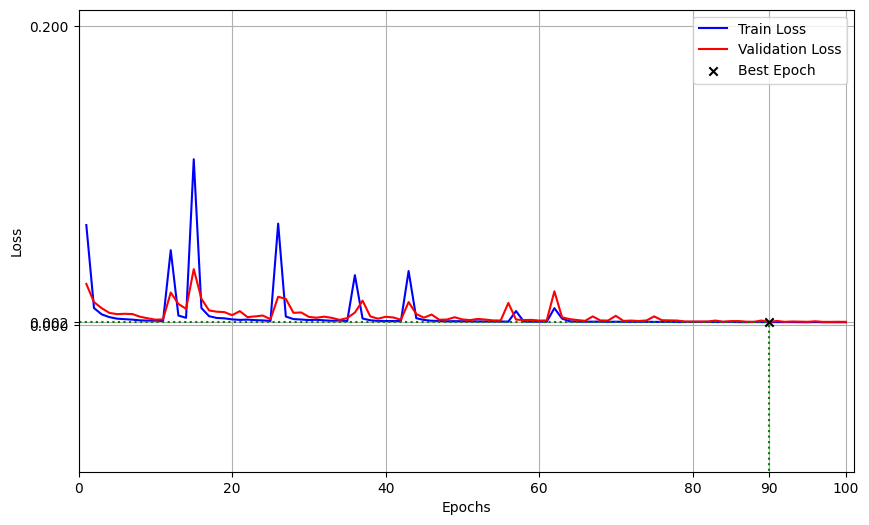

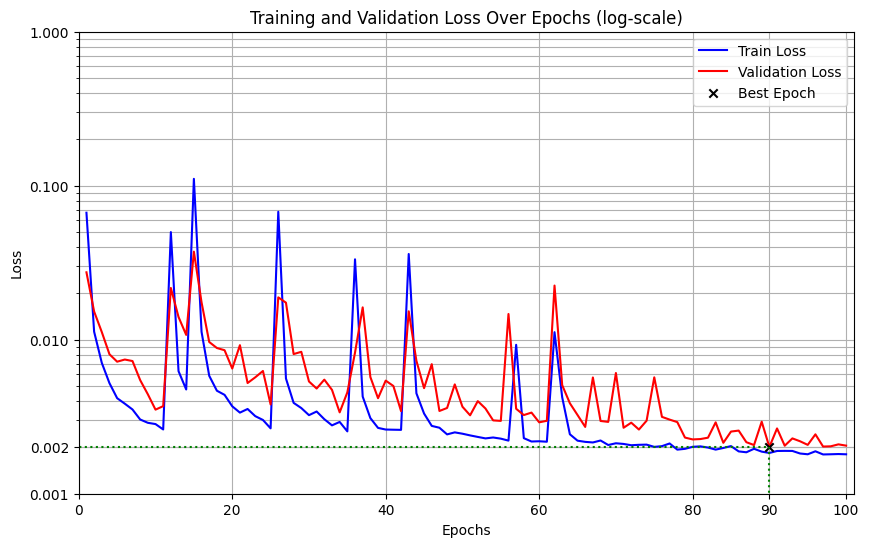

In [12]:
# Train the model
constants_scheduler = partial(Diffusion.cosine_beta_schedule, s=0.008)
losses_history=model_trainer.train(
    epochs=EPOCHS,
    timesteps=T,
    constants_scheduler=constants_scheduler,
    save_model_path=MODEL_SAVE_PATH,
    save_images_path=IMAGES_SAVE_PATH,
    save_intermediate_models=SAVE_INTERMEDIATE_MODELS,
    verbose=VERBOSE
)